# **Preparación entorno**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install wandb --quiet

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# **División dataset**

In [ ]:
# Cargamos valid y test
valid_df = pd.read_csv('/content/drive/MyDrive/TFM/splits/valid_split_bien.csv')
test_df = pd.read_csv('/content/drive/MyDrive/TFM/splits/test_split_bien.csv')

In [ ]:
# Cargamos train para el dataset de 600 muestras por clase
train_df_600 = pd.read_csv('/content/drive/MyDrive/TFM/data/train_df_600.csv')
# Convertimos a string para que los generadores
train_df_600["filepath"] = train_df_600["filepath"].astype(str)
train_df_600["label"] = train_df_600["label"].astype(str)

In [ ]:
# Cargamos los dataset aumentados artificialmente
def load_augmented_train_df(augmented_dir):
    filepaths = []
    labels = []

    for label in ['0', '1']:
        label_dir = os.path.join(augmented_dir, label)
        for fname in os.listdir(label_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(label_dir, fname))
                labels.append(label)

    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

In [ ]:
train_df_1000 = load_augmented_train_df('/content/drive/MyDrive/TFM/data/augmented_train_1000')
train_df_2000 = load_augmented_train_df('/content/drive/MyDrive/TFM/data/augmented_train_2000')
train_df_3000 = load_augmented_train_df('/content/drive/MyDrive/TFM/data/augmented_train_3000')

In [ ]:
# Generadores base
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

# Parámetros comunes
img_size = (224, 224)
batch_size = 16

valid_df["label"] = valid_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)

# Generadores de entrenamiento
train_gen_600 = tr_gen.flow_from_dataframe(train_df_600, x_col='filepath', y_col='label',
                                           class_mode='binary', target_size=img_size, batch_size=batch_size)

train_gen_1000 = tr_gen.flow_from_dataframe(train_df_1000, x_col='filepaths', y_col='labels',
                                            class_mode='binary', target_size=img_size, batch_size=batch_size)

train_gen_2000 = tr_gen.flow_from_dataframe(train_df_2000, x_col='filepaths', y_col='labels',
                                            class_mode='binary', target_size=img_size, batch_size=batch_size)

train_gen_3000 = tr_gen.flow_from_dataframe(train_df_3000, x_col='filepaths', y_col='labels',
                                            class_mode='binary', target_size=img_size, batch_size=batch_size)

# Validación y test
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepath', y_col='label',
                                       class_mode='binary', target_size=img_size, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepath', y_col='label',
                                      class_mode='binary', target_size=img_size, batch_size=batch_size, shuffle=False)

Found 1138 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.
Found 187 validated image filenames belonging to 2 classes.
Found 188 validated image filenames belonging to 2 classes.


# **Arquitectura modelo**

In [ ]:
# Creamos la métrica F1Score para evaluar el modelo
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.round(y_pred), tf.float32)
        y_true = tf.cast(tf.reshape(y_true, tf.shape(y_pred)), tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

        self.f1.assign_add(f1)
        self.count.assign_add(1.0)

    def result(self):
        return self.f1 / self.count

    def reset_states(self):
        self.f1.assign(0.0)
        self.count.assign(0.0)

In [ ]:
# Creamos la métrica Specificity para evaluar el modelo
class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name='specificity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.tn = self.add_weight(name='true_negatives', initializer='zeros')
        self.fp = self.add_weight(name='false_positives', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Asegura formas compatibles y valores float binarios
        y_pred = tf.cast(tf.round(y_pred), tf.float32)
        y_true = tf.cast(tf.reshape(y_true, tf.shape(y_pred)), tf.float32)

        tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)

        self.tn.assign_add(tn)
        self.fp.assign_add(fp)
        self.count.assign_add(1.0)

    def result(self):
        specificity = self.tn / (self.tn + self.fp + tf.keras.backend.epsilon())
        return specificity

    def reset_states(self):
        self.tn.assign(0.0)
        self.fp.assign(0.0)
        self.count.assign(0.0)

In [ ]:
# Tamaño de las imágenes
img_size = (224, 224)

# Número de canales (son 3 para imágenes RGB)
channels = 3

# Definimos el tamaño de las imágenes como 224x224x3
img_shape = (img_size[0], img_size[1], channels)

# Definimos el modelo con el nombre baseline_model
baseline_model = Sequential()

# Capa entrada
baseline_model.add(Input(shape=img_shape))

# Capa convolucional inicial
baseline_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
baseline_model.add(MaxPooling2D())

# Segunda capa convolucional
baseline_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
baseline_model.add(MaxPooling2D())

# Aplanamiento y capas densas
baseline_model.add(Flatten())
baseline_model.add(Dense(64, activation="relu"))
baseline_model.add(Dense(32, activation="relu"))

# Capa de salida para clasificación binaria
baseline_model.add(Dense(1, activation="sigmoid"))

# Compilación del modelo con binary_crossentropy
baseline_model.compile(
    optimizer=Adamax(),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        F1Score(name='F1 score'),
        Specificity(name='specificity')
    ]
)

In [ ]:
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,866,625 (49.08 MB)

 Trainable params: 12,866,625 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

# **Entrenamiento modelo**

In [ ]:
# Creamos una clase para guardar las métricas en Weights & Biases
class WandbLoggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            wandb.log(logs, step=epoch)

In [ ]:
# Login en Weights & Biases
wandb.login()

# Diccionario de generadores
train_generators = {
    "600": train_gen_600,
    "1000": train_gen_1000,
    "2000": train_gen_2000,
    "3000": train_gen_3000
}

# Para almacenar los historiales
histories = {}

for name in ["600", "1000", "2000", "3000"]:
    print(f"\n Entrenando modelo Baseline con {name} muestras")

    # Iniciamos nuevo proyecto en wandb
    wandb.init(
        project="mamografia clasificacion baseline",
        name=f"run_{name}_muestras",
        reinit=True
    )

    # Definimos ruta de guardado del modelo
    checkpoint_path = f"/content/drive/MyDrive/TFM/models/Baseline/model_best_{name}.weights.h5"

    checkpoint_callback = ModelCheckpoint(
        monitor='val_accuracy',
        mode='max',
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=5,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    callbacks = [
        checkpoint_callback,
        early_stop,
        WandbLoggingCallback()
    ]

    # Entrenamiento
    history = baseline_model.fit(
        train_generators[name],
        validation_data=valid_gen,
        batch_size=16,
        epochs=30,
        callbacks=callbacks
    )

    histories[name] = history
    wandb.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: elias-pallares (elias-pallares-universitat-pompeu-fabra) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



 Entrenando modelo Baseline con 600 muestras


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - F1 score: 0.4321 - accuracy: 0.5406 - auc: 0.5481 - loss: 0.8091 - precision: 0.5072 - recall: 0.5307 - specificity: 0.5479
Epoch 1: val_accuracy improved from -inf to 0.64171, saving model to /content/drive/MyDrive/TFM/models/Baseline/model_best_600.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 331s 5s/step - F1 score: 0.4329 - accuracy: 0.5412 - auc: 0.5488 - loss: 0.8078 - precision: 0.5080 - recall: 0.5305 - specificity: 0.5492 - val_F1 score: 0.4879 - val_accuracy: 0.6417 - val_auc: 0.6670 - val_loss: 0.6473 - val_precision: 0.5000 - val_recall: 0.4925 - val_specificity: 0.7250
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - F1 score: 0.6353 - accuracy: 0.6631 - auc: 0.7183 - loss: 0.6218 - precision: 0.6523 - recall: 0.6435 - specificity: 0.6764
Epoch 2: val_accuracy did not improve from 0.64171
72/72 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - F1 score: 0.6353 - accuracy: 0.6633 - auc: 0.7187 - loss: 0.6215 - precision: 0.6524 - recall: 0.64

F1 score,▁▄▄▅▆▇▇█
accuracy,▁▃▄▄▆▇██
auc,▁▄▄▅▆▇██
loss,█▆▆▅▄▃▂▁
precision,▁▃▄▄▅▆██
recall,▁▃▄▆▆███
specificity,▁▃▄▃▅▆██
val_F1 score,▃▆█▁▇█▂▅
val_accuracy,▅▄▆▄▄▅█▁
val_auc,▁▁▅▁▄█▇▃
val_loss,▂▃▁▂▂▃▄█



 Entrenando modelo Baseline con 1000 muestras


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - F1 score: 0.7193 - accuracy: 0.7075 - auc: 0.7746 - loss: 0.5669 - precision: 0.6952 - recall: 0.7718 - specificity: 0.6380
Epoch 1: val_accuracy improved from -inf to 0.65775, saving model to /content/drive/MyDrive/TFM/models/Baseline/model_best_1000.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 603s 5s/step - F1 score: 0.7193 - accuracy: 0.7076 - auc: 0.7746 - loss: 0.5668 - precision: 0.6952 - recall: 0.7718 - specificity: 0.6382 - val_F1 score: 0.3922 - val_accuracy: 0.6578 - val_auc: 0.6842 - val_loss: 0.6050 - val_precision: 0.5333 - val_recall: 0.3582 - val_specificity: 0.8250
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - F1 score: 0.7459 - accuracy: 0.7452 - auc: 0.8388 - loss: 0.5051 - precision: 0.7419 - recall: 0.7777 - specificity: 0.7131
Epoch 2: val_accuracy did not improve from 0.65775
125/125 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - F1 score: 0.7460 - accuracy: 0.7453 - auc: 0.8389 - loss: 0.5049 - precision: 0.7419 - rec

F1 score,▁▂▄▆▆█
accuracy,▁▂▄▆▇█
auc,▁▃▅▆▇█
loss,█▇▅▄▃▁
precision,▁▃▄▆▇█
recall,▁▂▃▅▆█
specificity,▁▃▄▆▇█
val_F1 score,▄▆▆▁██
val_accuracy,▅▁▆▆█▆
val_auc,▁▁▃▅██
val_loss,▁▂▂█▄▆



 Entrenando modelo Baseline con 2000 muestras


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - F1 score: 0.7233 - accuracy: 0.7248 - auc: 0.8005 - loss: 0.5386 - precision: 0.7098 - recall: 0.7628 - specificity: 0.6877
Epoch 1: val_accuracy improved from -inf to 0.63102, saving model to /content/drive/MyDrive/TFM/models/Baseline/model_best_2000.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1107s 4s/step - F1 score: 0.7234 - accuracy: 0.7249 - auc: 0.8005 - loss: 0.5385 - precision: 0.7098 - recall: 0.7629 - specificity: 0.6877 - val_F1 score: 0.4234 - val_accuracy: 0.6310 - val_auc: 0.7055 - val_loss: 0.6141 - val_precision: 0.4821 - val_recall: 0.4030 - val_specificity: 0.7583
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - F1 score: 0.8019 - accuracy: 0.8065 - auc: 0.8907 - loss: 0.4199 - precision: 0.7890 - recall: 0.8403 - specificity: 0.7727
Epoch 2: val_accuracy improved from 0.63102 to 0.71123, saving model to /content/drive/MyDrive/TFM/models/Baseline/model_best_2000.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step 

F1 score,▁▃▅▆██
accuracy,▁▃▅▇██
auc,▁▄▇▇██
loss,█▆▄▃▂▁
precision,▁▃▅▇██
recall,▁▃▅▆██
specificity,▁▃▅▇██
val_F1 score,▁█▄▅▄▅
val_accuracy,▁█▇▆▃▄
val_auc,▁█▇▆▇▄
val_loss,▁▁▂▄▅█



 Entrenando modelo Baseline con 3000 muestras


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - F1 score: 0.7814 - accuracy: 0.7837 - auc: 0.8749 - loss: 0.4444 - precision: 0.7554 - recall: 0.8313 - specificity: 0.7367
Epoch 1: val_accuracy improved from -inf to 0.66310, saving model to /content/drive/MyDrive/TFM/models/Baseline/model_best_3000.weights.h5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1825s 5s/step - F1 score: 0.7814 - accuracy: 0.7837 - auc: 0.8749 - loss: 0.4444 - precision: 0.7555 - recall: 0.8314 - specificity: 0.7368 - val_F1 score: 0.5488 - val_accuracy: 0.6631 - val_auc: 0.7287 - val_loss: 0.6766 - val_precision: 0.5213 - val_recall: 0.7313 - val_specificity: 0.6250
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - F1 score: 0.8870 - accuracy: 0.8956 - auc: 0.9615 - loss: 0.2618 - precision: 0.8803 - recall: 0.9134 - specificity: 0.8780
Epoch 2: val_accuracy did not improve from 0.66310
375/375 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - F1 score: 0.8871 - accuracy: 0.8957 - auc: 0.9615 - loss: 0.2618 - precision: 0.8803 - re

F1 score,▁▅▇███
accuracy,▁▅▇███
auc,▁▆████
loss,█▅▃▂▁▁
precision,▁▅▇███
recall,▁▄▇▇██
specificity,▁▅▇███
val_F1 score,▇▂█▁▅▃
val_accuracy,▇▅▁▇▇█
val_auc,▇█▁▂█▆
val_loss,▁▂█▇▅▅


# **Perfomance**

 ## Comparando métricas de entrenamiento y validación

In [ ]:
def plot_training_curves(history, title_prefix='', save_dir='/content/drive/MyDrive/TFM/plots/'):
    # Extraemos los valores de accuracy y loss del entrenamiento y validación
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Encontramos el índice (epoch) con la menor pérdida de validación
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    # Encontramos el índice (epoch) con la mayor accuracy de validación
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    # Creamos una lista con los números de época
    Epochs = [i+1 for i in range(len(tr_acc))]

    # Etiquetas para marcar las mejores epoch en las gráficas
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    # Definimos el tamaño de la figura
    plt.figure(figsize=(20, 8))
    #Gráfico loss
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title(f'{title_prefix} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    #Gráfico accuracy
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title(f'{title_prefix} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Ajustamos el diseño para que no se sobrepongan los elementos
    plt.tight_layout()
    # Establecemos ruta de guardado de las figuras en formato png
    os.makedirs(save_dir, exist_ok=True)
    filename = title_prefix.strip().replace(' ', '_').replace('-', '') + ".png"
    filepath = os.path.join(save_dir, f"training_curve_{filename}")
    plt.savefig(filepath)
    print(f" Gráfico guardado en: {filepath}")
    plt.show()

 Gráfico guardado en: /content/drive/MyDrive/TFM/plots/training_curve_Baseline__600_muestras.png


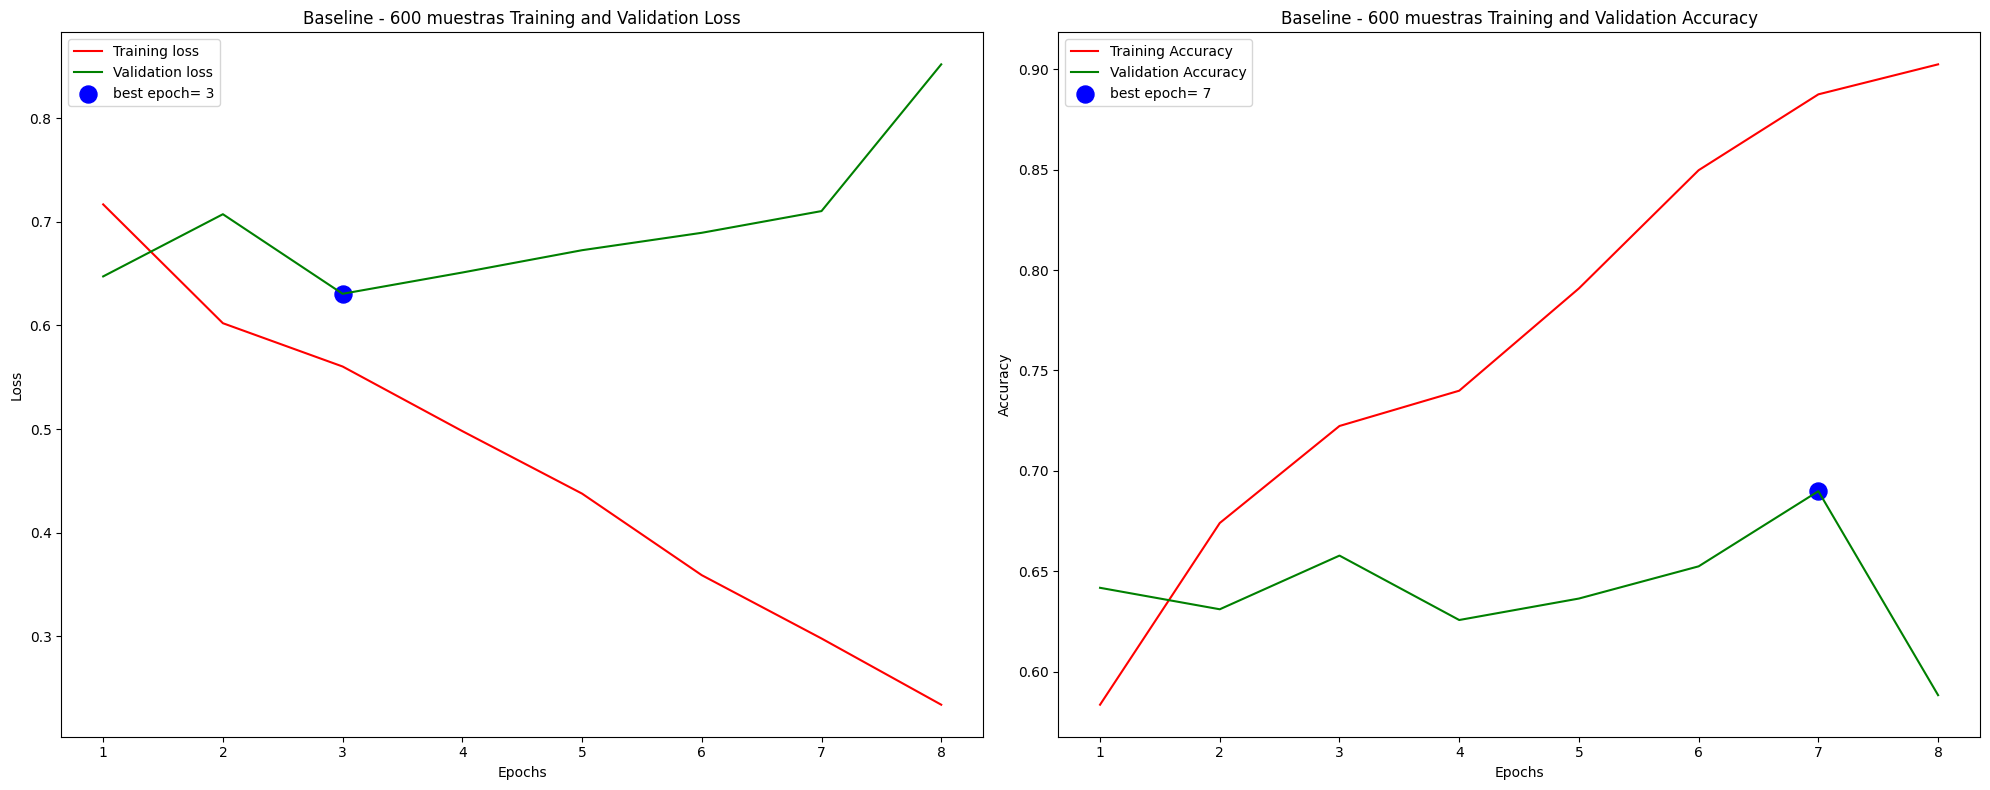

 Gráfico guardado en: /content/drive/MyDrive/TFM/plots/training_curve_Baseline__1000_muestras.png


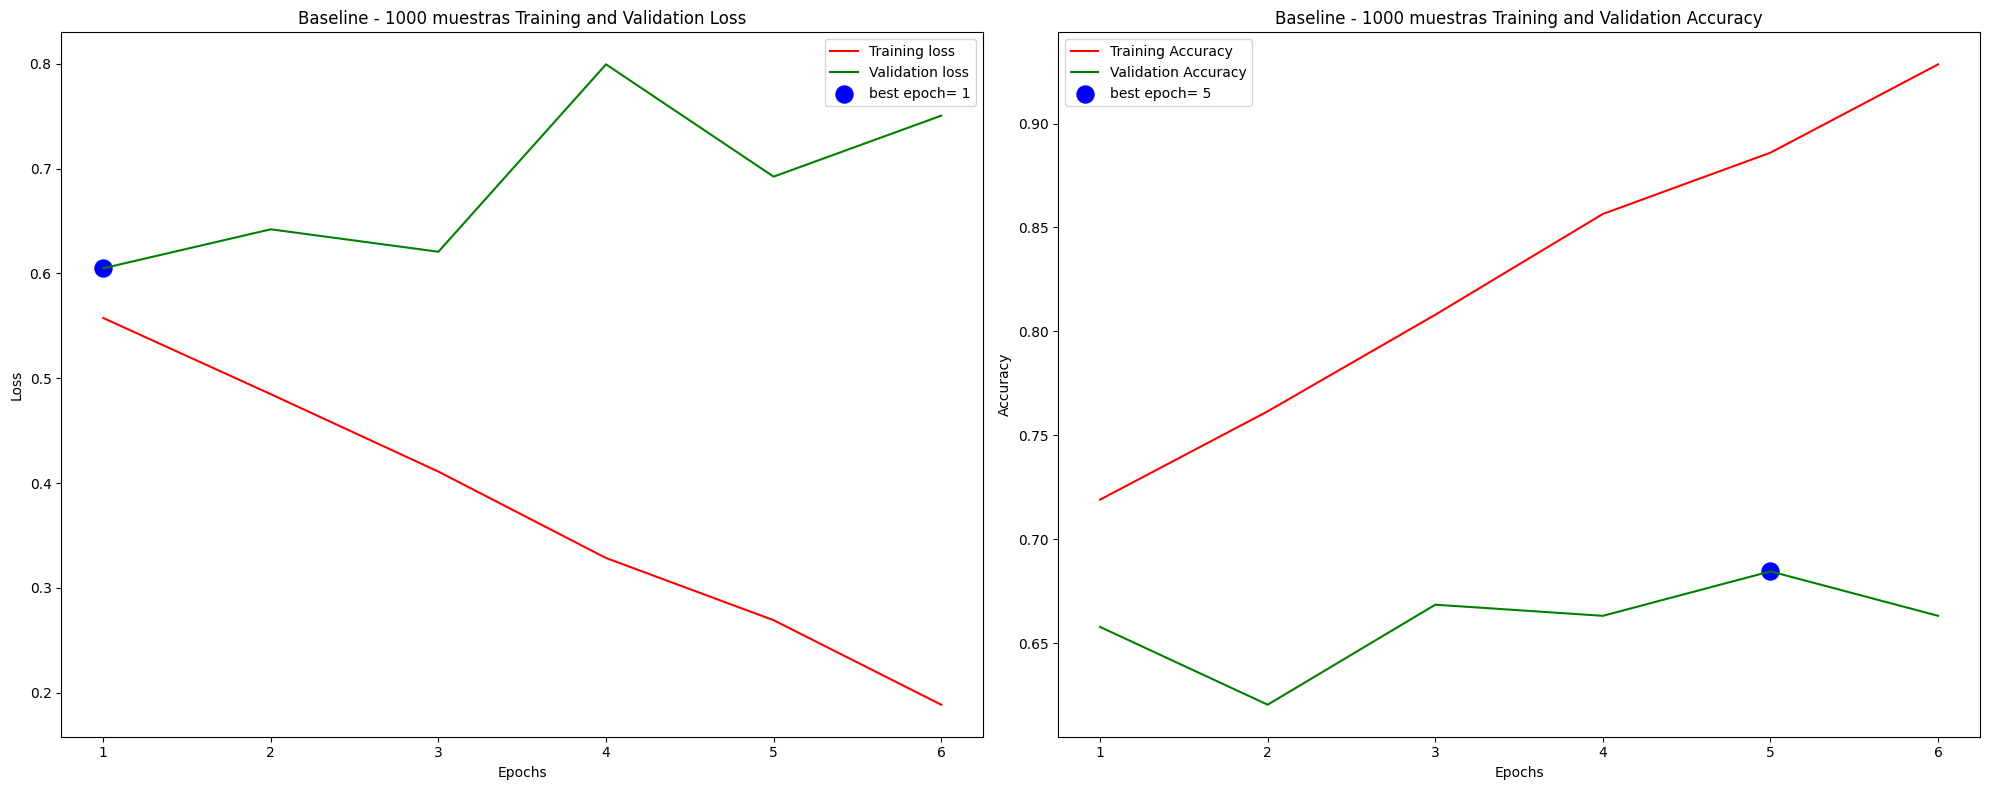

 Gráfico guardado en: /content/drive/MyDrive/TFM/plots/training_curve_Baseline__2000_muestras.png


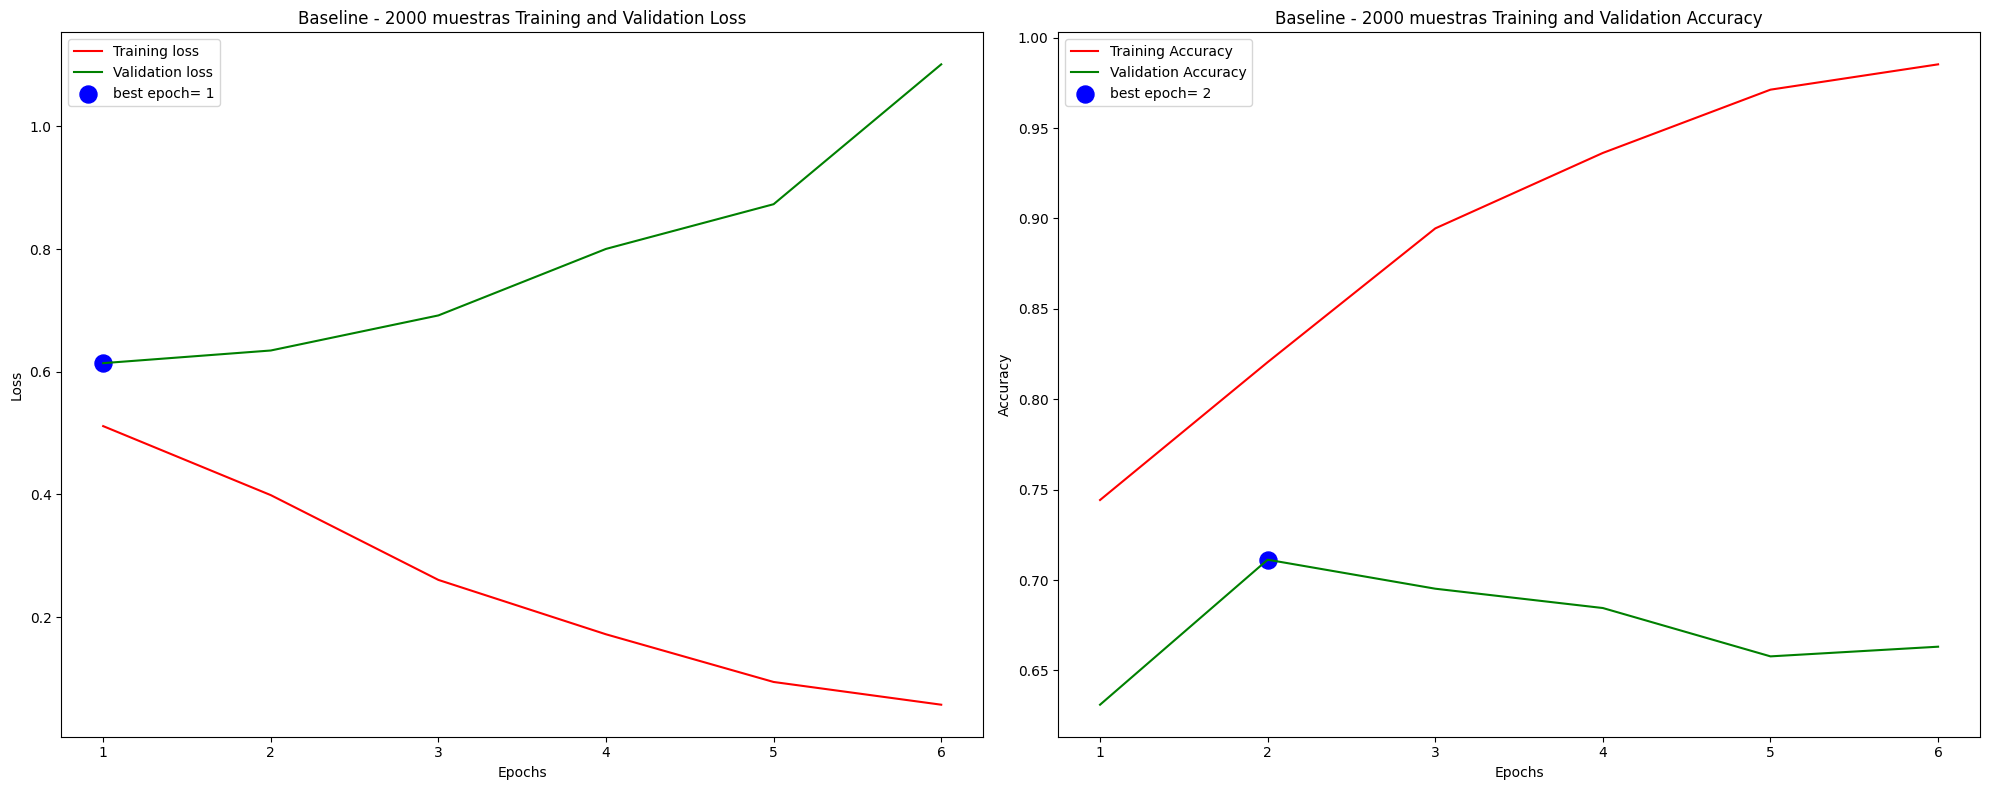

 Gráfico guardado en: /content/drive/MyDrive/TFM/plots/training_curve_Baseline__3000_muestras.png


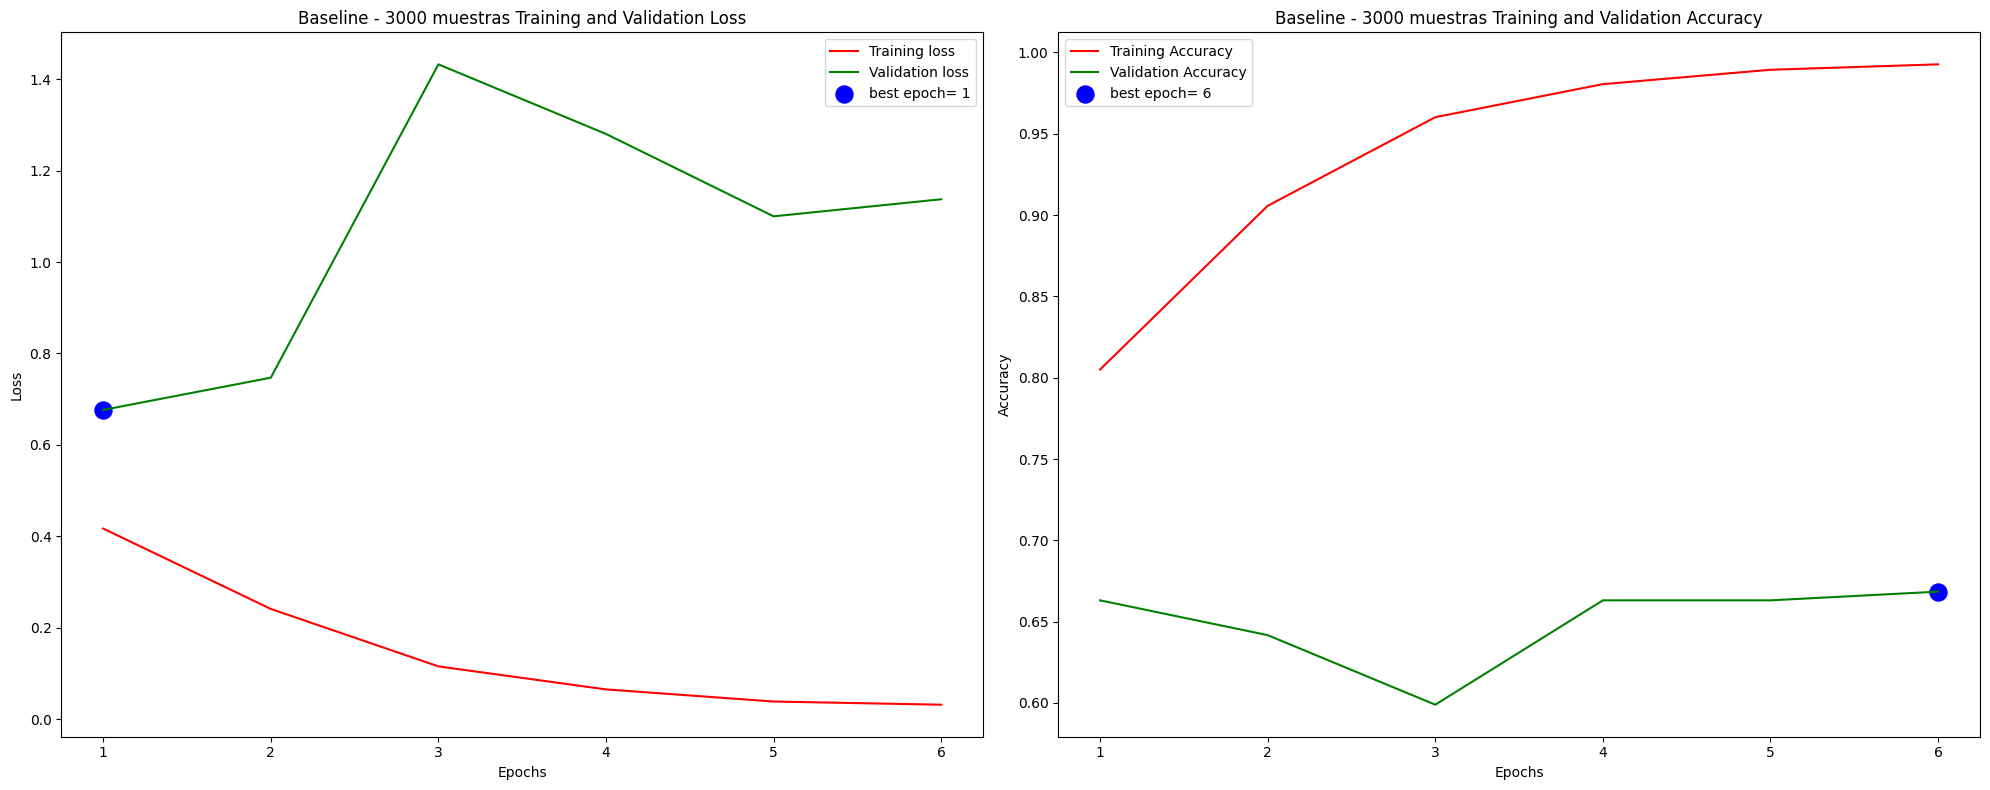

In [ ]:
for name, history in histories.items():
    plot_training_curves(history, title_prefix=f'Baseline - {name} muestras')

## Evaluación métricas validación

In [ ]:
def plot_metrics(history, title_prefix='', save_dir='/content/drive/MyDrive/TFM/plots/'):
    # Métricas a graficar
    metrics_to_plot = [
        'val_accuracy', 'val_precision', 'val_recall',
        'val_F1 score', 'val_auc', 'val_specificity'
    ]
    metric_names = {
        'val_accuracy': 'Accuracy',
        'val_precision': 'Precision',
        'val_recall': 'Recall',
        'val_F1 score': 'F1-score',
        'val_auc': 'AUC',
        'val_specificity': 'Specificity'
    }

    # Eje x
    epochs = range(1, len(history.history['val_accuracy']) + 1)

    # Creamos figura
    plt.figure(figsize=(22, 10))

    for i, metric in enumerate(metrics_to_plot, 1):
        if metric in history.history:
            values = history.history[metric]
            best_epoch = np.argmax(values)
            best_value = values[best_epoch]

            plt.subplot(2, 3, i)
            plt.plot(epochs, values, label=metric_names[metric], linewidth=2)
            plt.scatter(best_epoch + 1, best_value, s=100, c='red', label=f'Best = {best_value:.4f}')
            plt.title(f'{metric_names[metric]} por epochs', fontsize=14)
            plt.xlabel('Epoch')
            plt.ylabel(metric_names[metric])
            plt.legend()

    plt.suptitle(f'{title_prefix}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Establecemos ruta de guardado de las figuras en formato png
    os.makedirs(save_dir, exist_ok=True)
    filename = title_prefix.strip().replace(' ', '_').replace('-', '') + ".png"
    filepath = os.path.join(save_dir, f"metrics_{filename}")
    plt.savefig(filepath)
    print(f"Gráfico guardado en: {filepath}")
    plt.show()

Gráfico guardado en: /content/drive/MyDrive/TFM/plots/metrics_Baseline__600_muestras.png


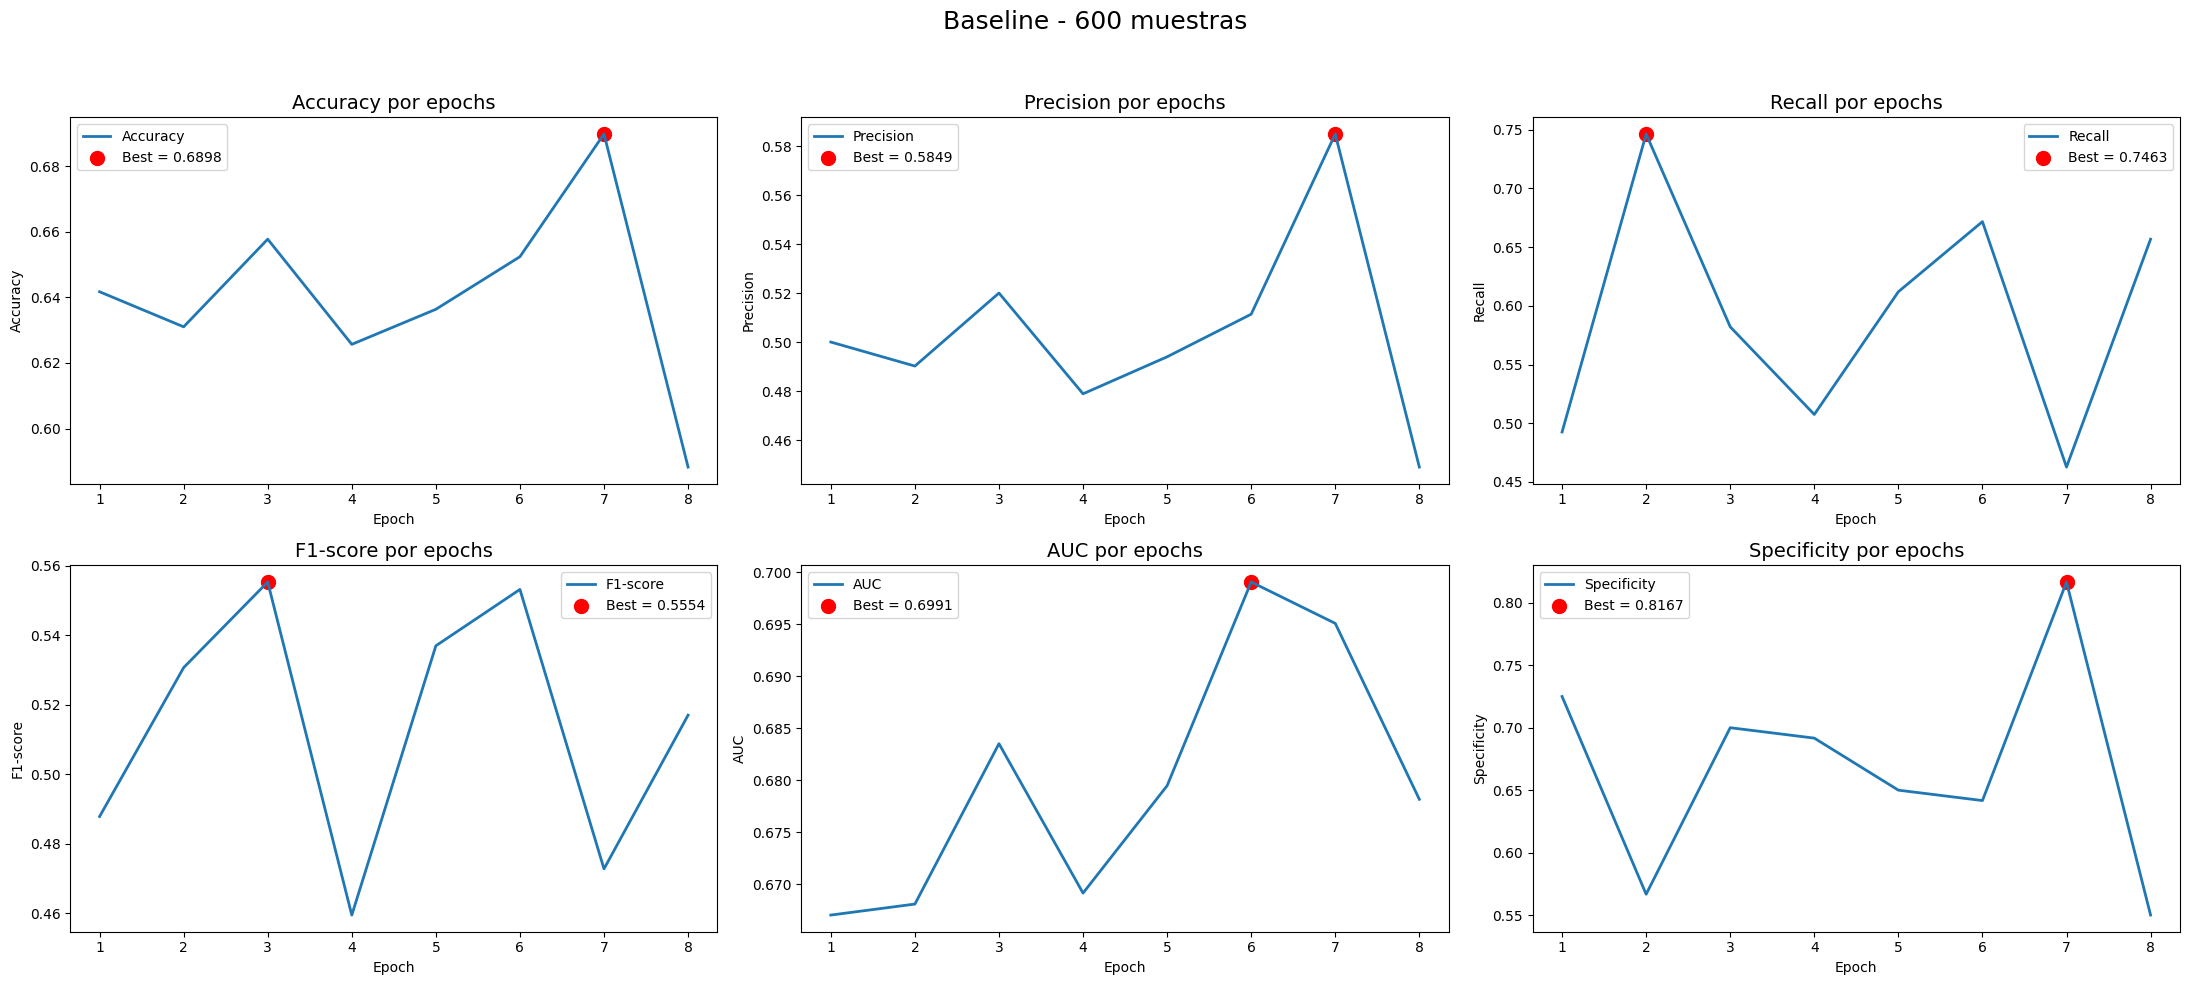

Gráfico guardado en: /content/drive/MyDrive/TFM/plots/metrics_Baseline__1000_muestras.png


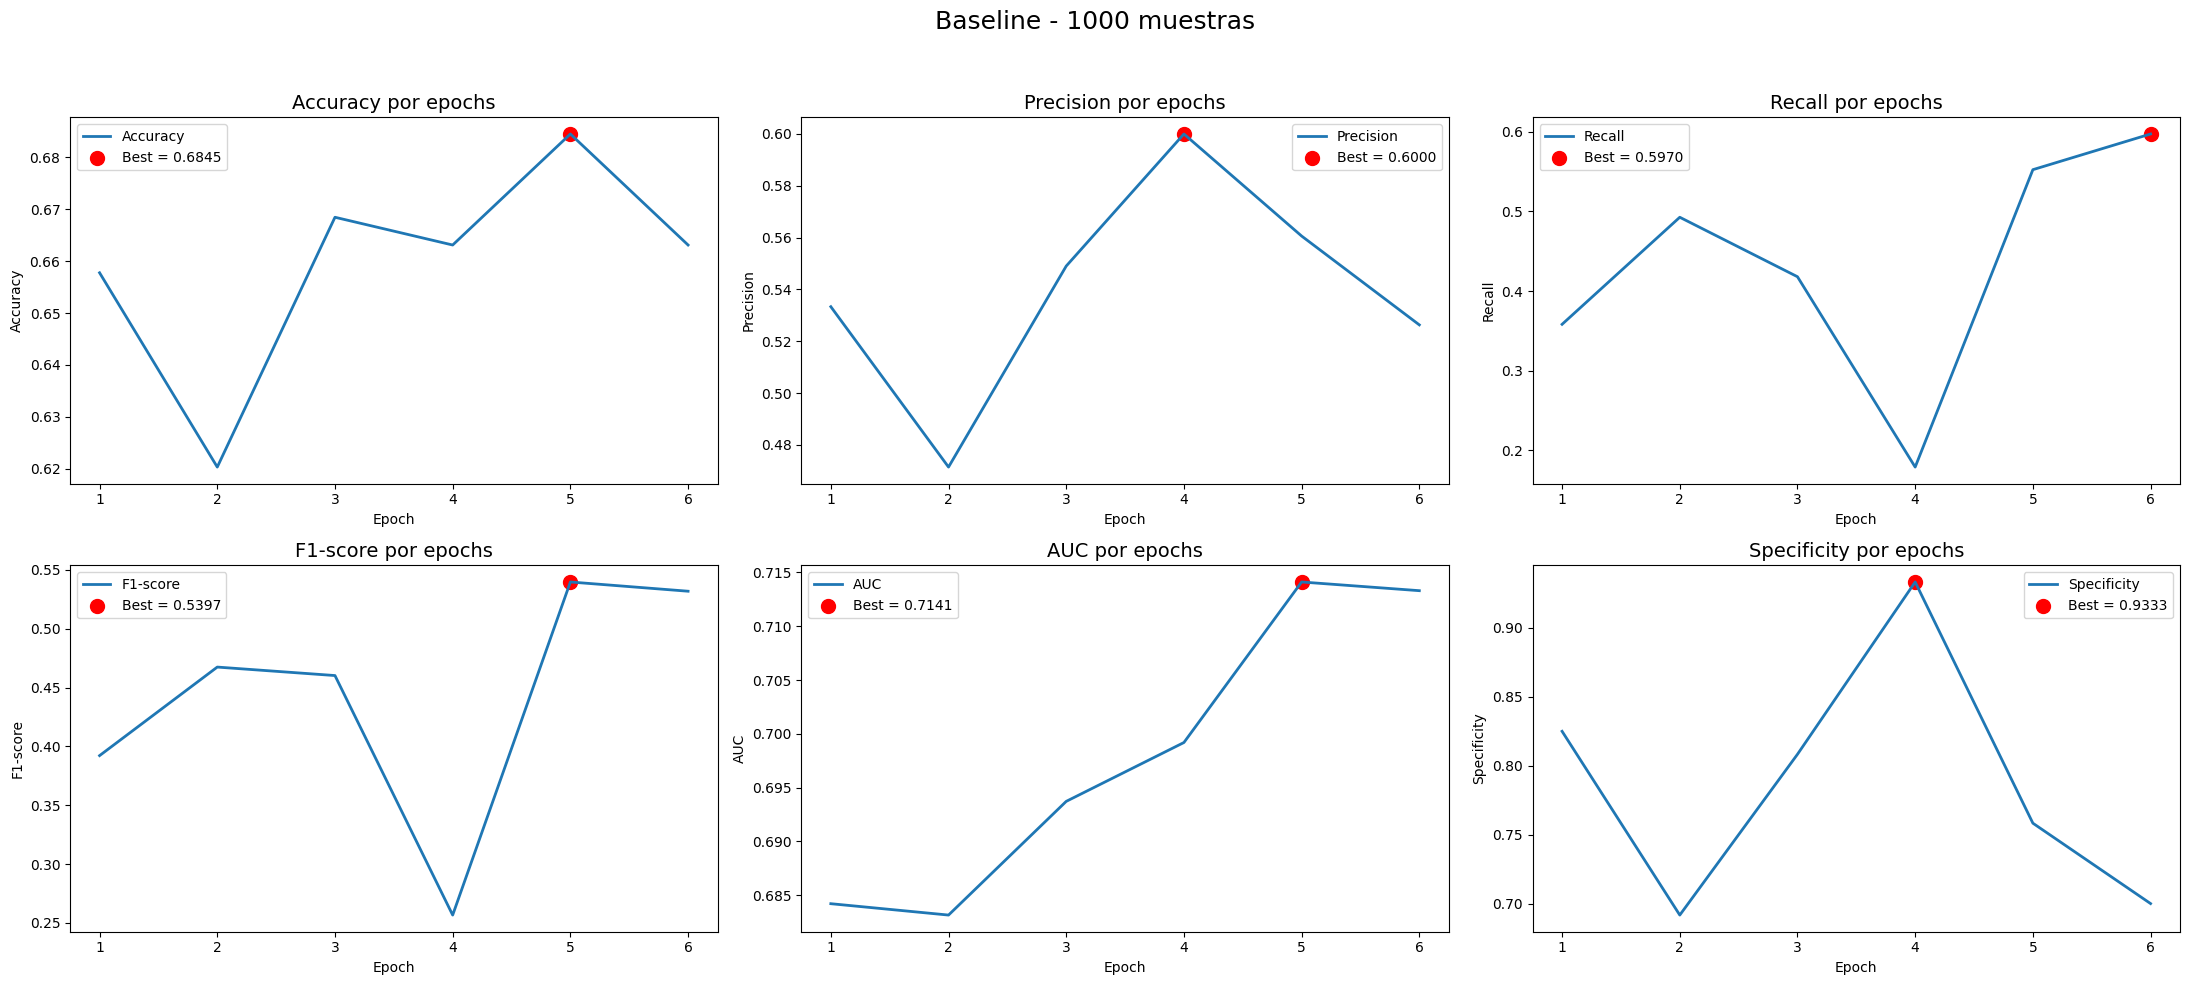

Gráfico guardado en: /content/drive/MyDrive/TFM/plots/metrics_Baseline__2000_muestras.png


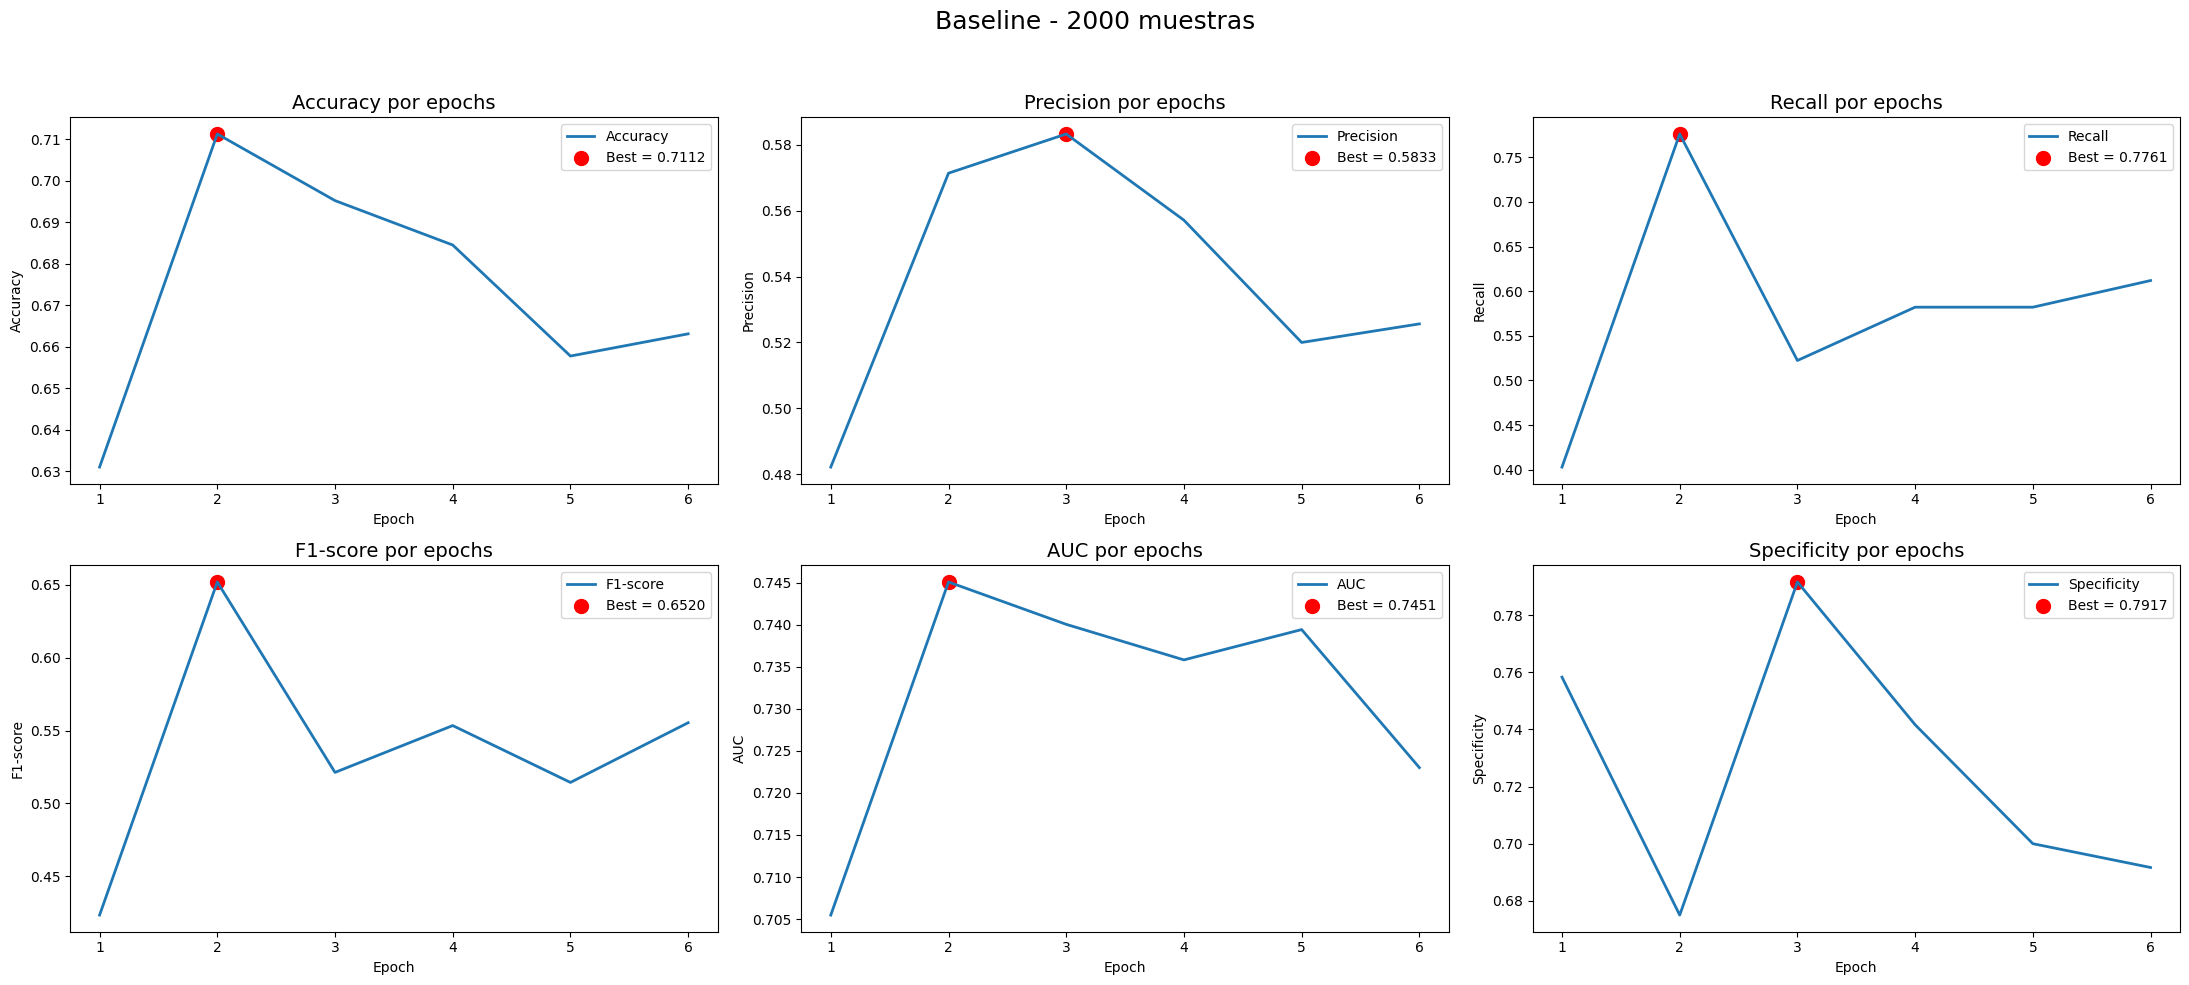

Gráfico guardado en: /content/drive/MyDrive/TFM/plots/metrics_Baseline__3000_muestras.png


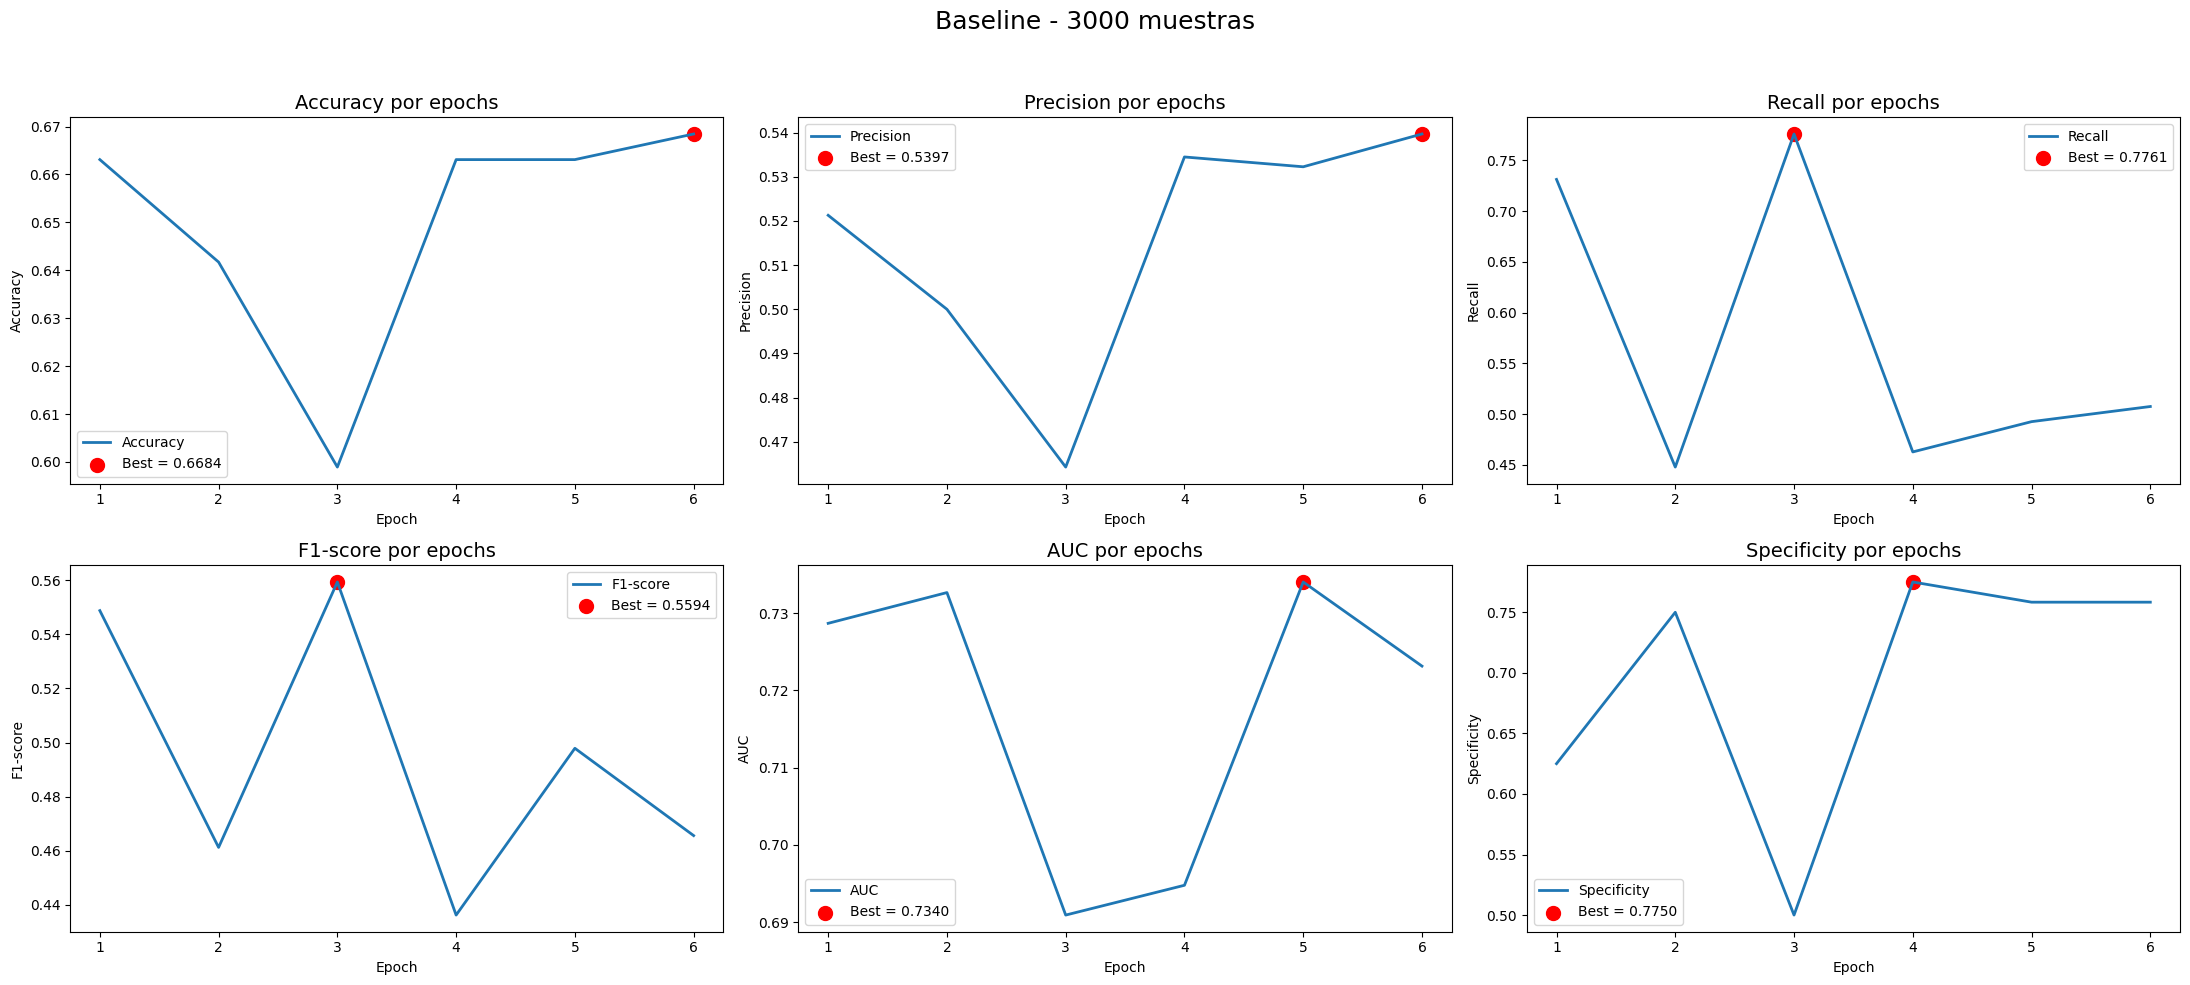

In [ ]:
for name, history in histories.items():
    plot_metrics(history, title_prefix=f'Baseline - {name} muestras')

# **Evaluación y predicción**


Evaluando modelo con 3000 muestras
 Pesos cargados: /content/drive/MyDrive/TFM/models/Baseline/model_best_3000.weights.h5
Accuracy:     0.7660
Precision:    0.6818
Recall:       0.6618
Specificity:  0.8250
F1-score:     0.6661
AUC:          0.8300
Loss:         0.8355

Classification Report:
              precision    recall  f1-score   support

      Benign     0.8115    0.8250    0.8182       120
   Malignant     0.6818    0.6618    0.6716        68

    accuracy                         0.7660       188
   macro avg     0.7466    0.7434    0.7449       188
weighted avg     0.7646    0.7660    0.7652       188

 Matriz de confusión guardada: /content/drive/MyDrive/TFM/plots/evaluation/Baseline/confusion_matrix_3000.png


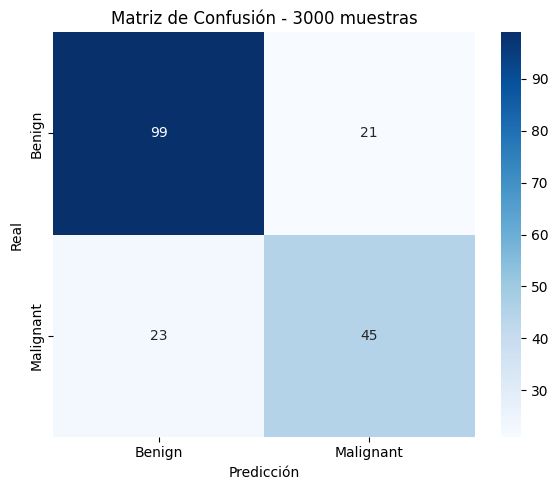

 Curva ROC guardada: /content/drive/MyDrive/TFM/plots/evaluation/Baseline/roc_curve_3000.png


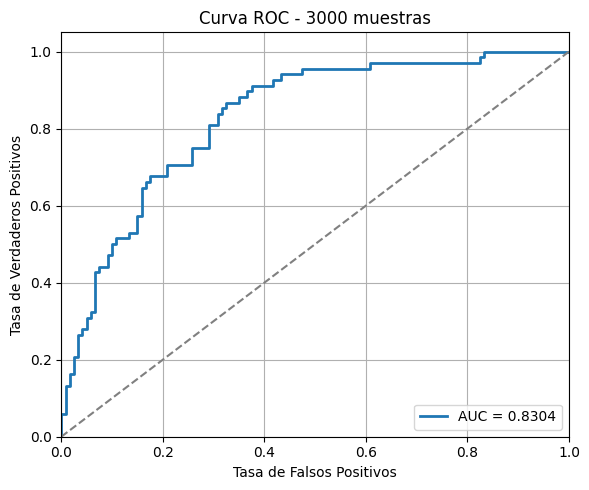

In [ ]:
# Ruta donde guardamos las figuras
eval_plot_dir = '/content/drive/MyDrive/TFM/plots/evaluation/Baseline'
os.makedirs(eval_plot_dir, exist_ok=True)

# Diccionario para guardar evaluaciones
evaluations = {}

# Evaluamos modelo con 3000 muestras
name = "3000"
print(f"\nEvaluando modelo con {name} muestras")

# Cargamos pesos
model_path = f"/content/drive/MyDrive/TFM/models/Baseline/model_best_{name}.weights.h5"
baseline_model.load_weights(model_path)
print(f" Pesos cargados: {model_path}")

# Evaluamos
evaluation_metrics = baseline_model.evaluate(test_gen, verbose=0, return_dict=True)
evaluations[name] = evaluation_metrics

# Mostramos métricas
print(f"Accuracy:     {evaluation_metrics.get('accuracy', 0):.4f}")
print(f"Precision:    {evaluation_metrics.get('precision', 0):.4f}")
print(f"Recall:       {evaluation_metrics.get('recall', 0):.4f}")
print(f"Specificity:  {evaluation_metrics.get('specificity', 0):.4f}")
print(f"F1-score:     {evaluation_metrics.get('F1 score', 0):.4f}")
print(f"AUC:          {evaluation_metrics.get('auc', 0):.4f}")
print(f"Loss:         {evaluation_metrics.get('loss', 0):.4f}")

# Predicciones
test_gen.reset()
y_pred_probs = baseline_model.predict(test_gen, verbose=0).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = test_gen.classes

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=["Benign", "Malignant"],
    digits=4
))

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.title(f'Matriz de Confusión - {name} muestras')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
conf_path = os.path.join(eval_plot_dir, f"confusion_matrix_{name}.png")
plt.savefig(conf_path)
print(f" Matriz de confusión guardada: {conf_path}")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title(f'Curva ROC - {name} muestras')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
roc_path = os.path.join(eval_plot_dir, f"roc_curve_{name}.png")
plt.savefig(roc_path)
print(f" Curva ROC guardada: {roc_path}")
plt.show()